In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/danbi/userdata/DANBI/gugakwon/SejongMusic


In [36]:
from omegaconf import OmegaConf
from sejong_music.model_zoo import JeongganTransSeq2seq
from sejong_music.jg_code import JeongganDataset, JeongganTokenizer, ABCDataset, ABCTokenizer
from sejong_music.inference import JGInferencer, JGSimpleInferencer, ABCInferencer
from sejong_music.jg_to_staff_converter import JGToStaffConverter

In [44]:
config = OmegaConf.load('wandb/run-20240408_001703-2qe7mqg5/files/checkpoints/config.yaml')
dataset = ABCDataset(is_valid=True, is_pos_counter=True)
tokenizer = ABCTokenizer(None, None, json_fn='wandb/run-20240408_001703-2qe7mqg5/files/checkpoints/tokenizer_vocab.json')
dataset.tokenizer = tokenizer
model = JeongganTransSeq2seq(tokenizer, config.model)
inferencer = ABCInferencer(model, is_condition_shifted=True, is_orch=True)
# import torch
state_dict = torch.load('wandb/run-20240408_001703-2qe7mqg5/files/checkpoints/inst_0/best_loss_model.pt', map_location='cpu')
model.load_state_dict(state_dict)
model.cuda()
model.eval()
None
decoder = JGToStaffConverter()

['pad', 'start', 'end', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 21, 23, Fraction(1, 6), Fraction(1, 4), Fraction(1, 3), Fraction(1, 2), Fraction(7, 12), Fraction(2, 3), Fraction(3, 4), Fraction(5, 6), Fraction(7, 6), Fraction(4, 3), Fraction(3, 2), Fraction(5, 3), Fraction(7, 4), Fraction(11, 6), Fraction(7, 3), Fraction(5, 2), Fraction(8, 3), Fraction(17, 6), Fraction(10, 3), Fraction(11, 3), Fraction(23, 6), Fraction(13, 3), Fraction(9, 2), Fraction(14, 3), Fraction(17, 3), Fraction(35, 6), Fraction(19, 3), Fraction(20, 3), Fraction(23, 3), Fraction(59, 6), Fraction(38, 3), Fraction(7, 2), Fraction(11, 4), Fraction(17, 2), Fraction(13, 1), Fraction(15, 4), Fraction(19, 4), Fraction(11, 2), Fraction(5, 4), Fraction(15, 2), Fraction(13, 6), Fraction(19, 6), Fraction(29, 3), Fraction(32, 3), Fraction(44, 3), Fraction(23, 2), Fraction(9, 4), Fraction(31, 6), Fraction(29, 6), Fraction(34, 3), Fraction(22, 3), Fraction(16, 3), Fraction(53, 6), Fraction(77, 6), '하하배임', '하배황', '하배태', '하배중', '하

In [47]:
src, tgt, shifted_tgt = dataset[100]

source, output, _ = inferencer.inference(src, inst_name='daegeum')

  0%|          | 0/3000 [00:00<?, ?it/s]

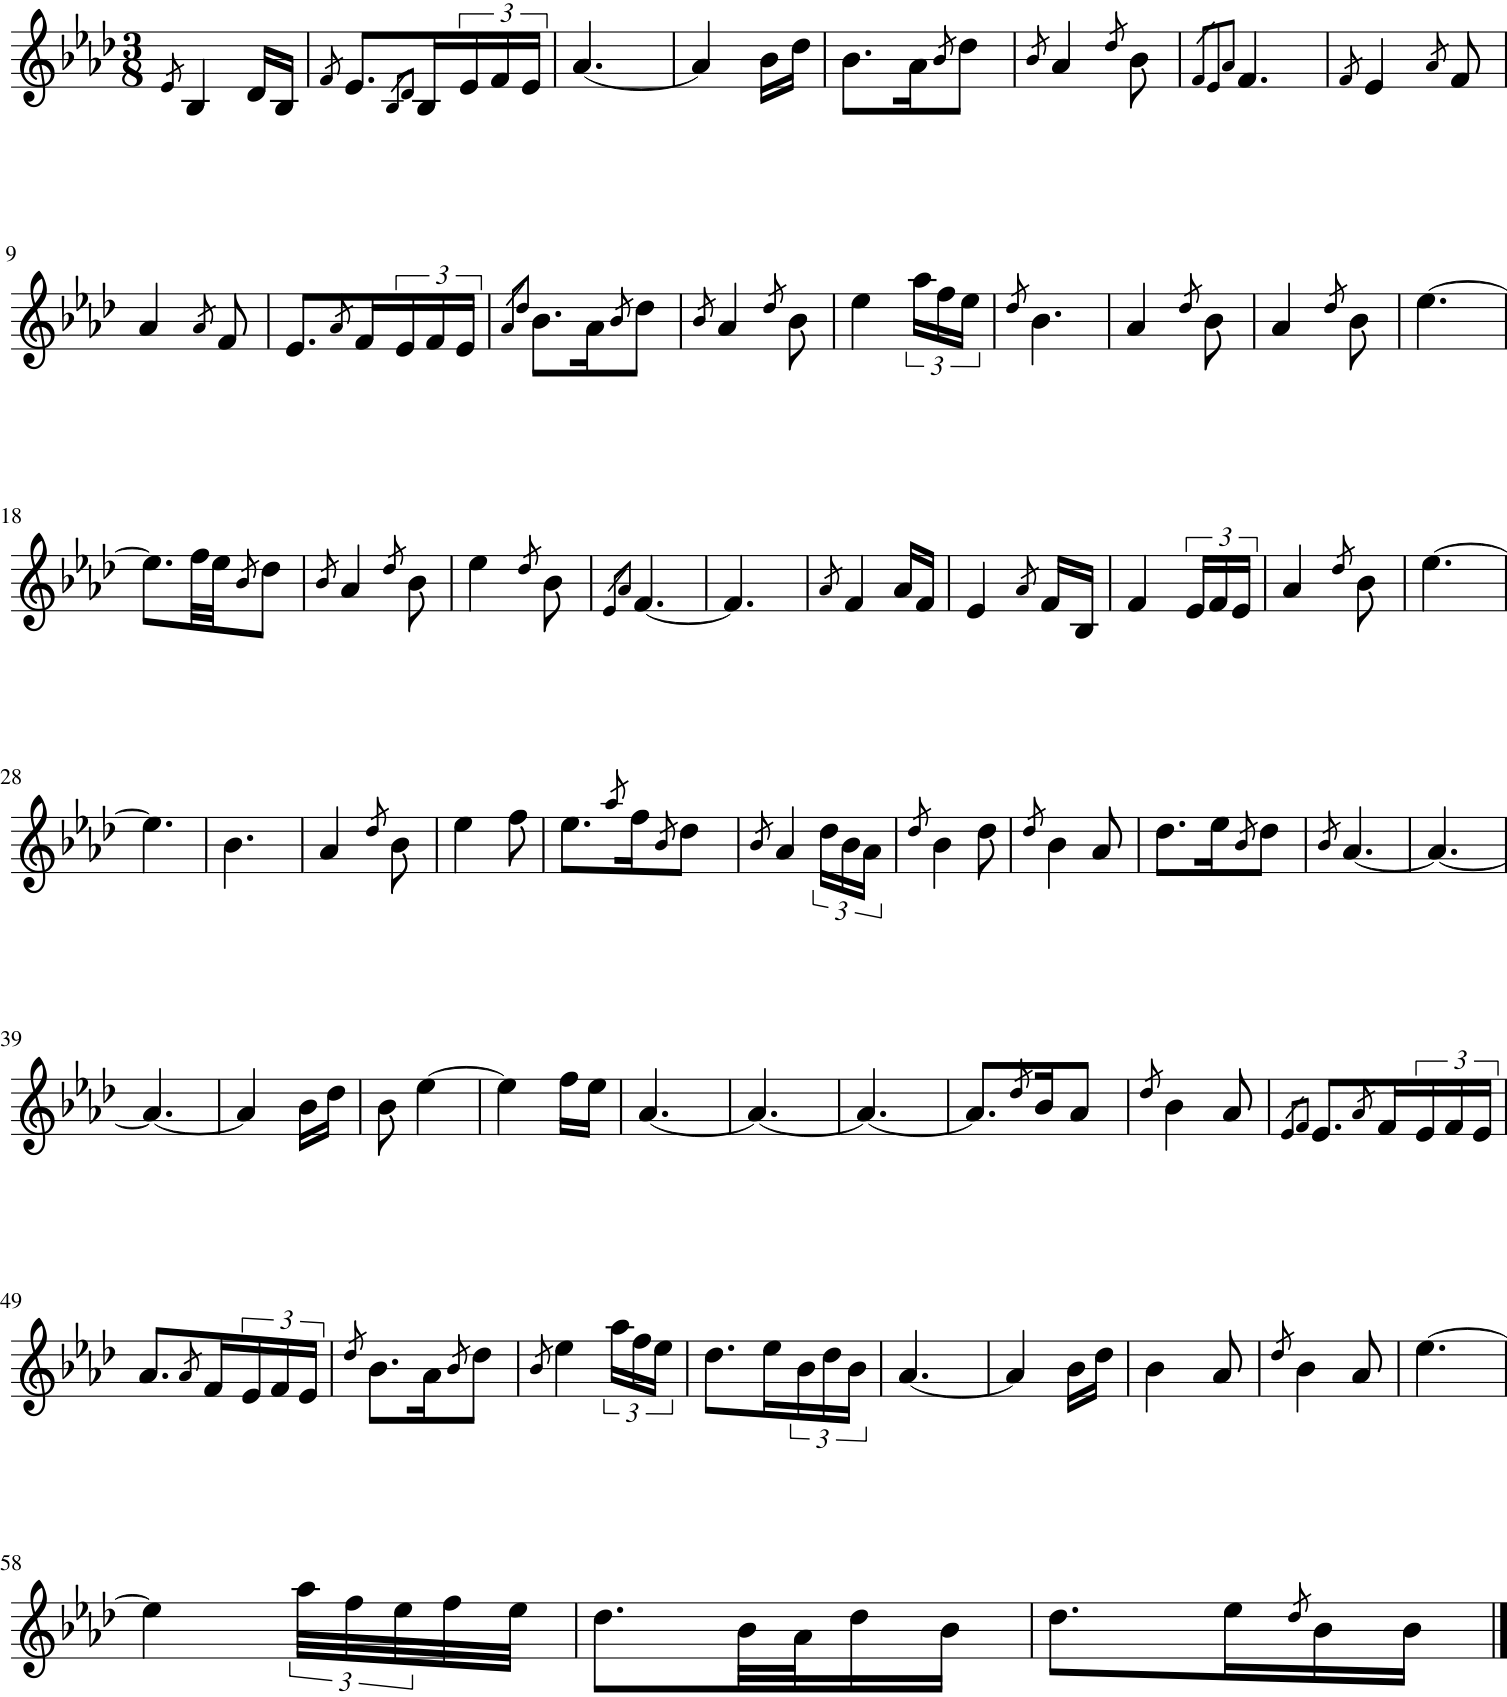

In [48]:
tokens = [x[0] for x in output]
notes, score = decoder.convert_abc_tokens(tokens)
score.show()

Unknown pitch 청협 in ABCNote(청협_, 1, 0, False)
Unknown ornament 미는표 in ABCNote(청중_미는표, 2/3, 4, False)
Unknown pitch 청무 in ABCNote(청무_, 1, 8, False)
Unknown ornament 농음표 in ABCNote(청중_농음표, 5/3, 11, False)
Unknown ornament 떠이어표 in ABCNote(청임_떠이어표, 2/3, 13, False)
Unknown pitch 청무 in ABCNote(청무_, 2/3, 52/3, False)
Unknown pitch 청무 in ABCNote(청무_, 2/3, 55/3, False)


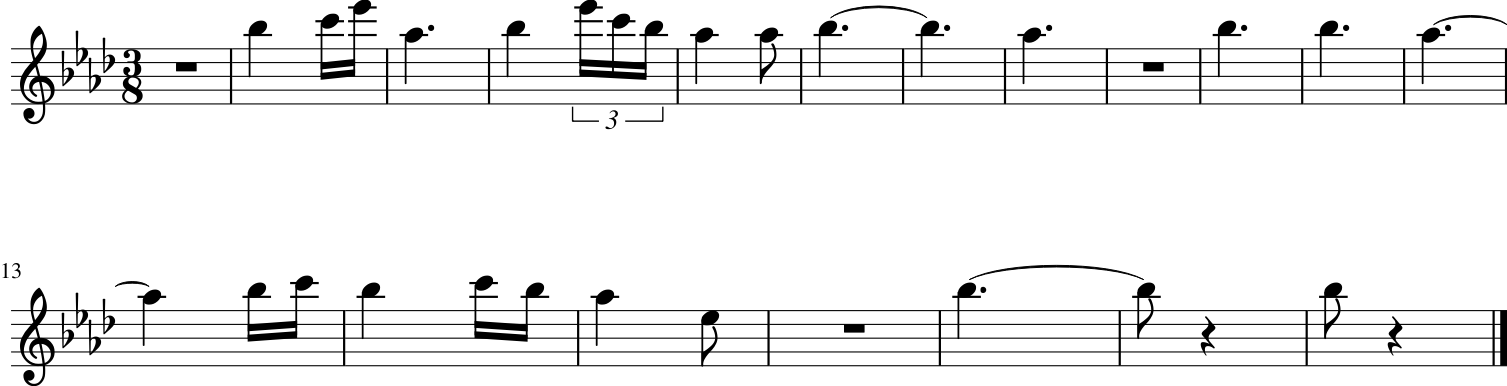

In [29]:
from typing import List
from sejong_music.jg_to_staff_converter import Note, JGToStaffConverter

cls = JGToStaffConverter
decoder = cls()

class ABCNote:
  def __init__(self, pitch:List[str], duration:float, global_offset:float):
    self.pitch = pitch[0]
    self.ornaments = pitch[1:]
    self.duration = duration
    self.global_offset = global_offset
    self.is_rest = self.pitch == '쉼표'
    self.midi_pitch = None
    self.m21_notes = []

  def __repr__(self) -> str:
    return f"ABCNote({self.pitch}_{'_'.join(self.ornaments)}, {self.duration}, {self.global_offset}, {self.is_rest})"


global_offset = 0
jg_offset = 0
gak_offset = 0
prev_pos = None
prev_note = []
total_notes = []
prev_duration = 0

for token in tokens:
  if token == '' or token in ('pad', 'start', 'end'): continue
  if token in cls.dur_tokens:
    duration = token
    if prev_note:
      total_notes.append(ABCNote(prev_note, duration, global_offset))
      prev_note = []
    global_offset += duration
    jg_offset += duration
  elif token  == '\n':
    gak_offset += 1
    jg_offset = 0
  else:
    prev_note.append(token)
# total_notes 
decoder.create_m21_notes(total_notes, verbose=True)
stream = decoder.convert_m21_notes_to_stream(total_notes)
stream.show()



In [32]:
tokens

['청협',
 1,
 '청임',
 Fraction(2, 3),
 '느니',
 Fraction(1, 3),
 '청중',
 1,
 '청임',
 Fraction(2, 3),
 '니레나',
 Fraction(1, 3),
 '청중',
 '미는표',
 Fraction(2, 3),
 '청중',
 Fraction(1, 3),
 '청임',
 2,
 '\n',
 '청중',
 1,
 '청무',
 1,
 '청임',
 1,
 '청임',
 1,
 '청중',
 '농음표',
 Fraction(5, 3),
 '느니',
 Fraction(1, 3),
 '\n',
 '청임',
 '떠이어표',
 Fraction(2, 3),
 '니나*',
 Fraction(1, 3),
 '청중',
 Fraction(2, 3),
 '청황',
 Fraction(1, 3),
 '쉼표',
 1,
 '청임',
 Fraction(4, 3),
 '청무',
 Fraction(2, 3),
 '청임',
 Fraction(1, 3),
 '청무',
 Fraction(2, 3)]

In [31]:
' '.join(tokens)

TypeError: sequence item 1: expected str instance, int found

In [4]:
decoder = JGToStaffConverter(dur_ratio=1.5)

In [ ]:
from sejong_music.jg_to_staff_converter import SigimsaeConverter

self = decoder
scale = None

if isinstance(tokens, str):
  tokens = tokens.split(' ')

notes = self.convert_to_notes(tokens)
if scale is None:
  scale, exceptional_pitches = self.get_scale(notes)
print(f'scale: {scale}')
if len(scale) < 4: 
  self.pitch_converter = SigimsaeConverter() # use default scale
else:
  self.pitch_converter = SigimsaeConverter(scale=scale, exceptional_pitches=exceptional_pitches)
self._fix_three_col_division(notes)
self.get_duration_of_notes(notes)
notes


In [108]:
from sejong_music.jg_code import JeongganDataset, JeongganTokenizer, ABCDataset, ABCTokenizer
from sejong_music.model_zoo import JeongganTransSeq2seq
from sejong_music.inference import JGInferencer, JGSimpleInferencer, ABCInferencer


abc_set = ABCDataset(is_valid=True)

In [109]:
tokens = abc_set.tokenizer.decode(abc_set[0][2])

In [110]:
tokens

['임',
 '니나',
 2,
 '중',
 1,
 '태',
 Fraction(1, 2),
 '노',
 Fraction(1, 6),
 '중',
 Fraction(1, 3),
 '태',
 '너녜',
 Fraction(2, 3),
 '쉼표',
 Fraction(1, 3),
 '\n',
 '임',
 Fraction(1, 6),
 '청황',
 Fraction(1, 3),
 '니',
 Fraction(1, 6),
 '남',
 Fraction(1, 3),
 '임',
 Fraction(1, 2),
 '니',
 Fraction(1, 6),
 '느나',
 '반길이표/덧길이표',
 Fraction(1, 3),
 '임',
 Fraction(1, 6),
 '청황',
 Fraction(1, 3),
 '니',
 Fraction(1, 6),
 '임',
 '노니로',
 Fraction(1, 3),
 '중',
 Fraction(1, 3),
 '쉼표',
 Fraction(1, 3),
 '중',
 7,
 '쉼표',
 Fraction(1, 3),
 '태',
 Fraction(1, 3),
 '임',
 Fraction(5, 3),
 '중',
 1,
 '태',
 Fraction(11, 6),
 '배남',
 Fraction(1, 6),
 '\n',
 '태',
 '나니로',
 Fraction(3, 2),
 '노',
 Fraction(1, 6),
 '중',
 Fraction(1, 3),
 '배남',
 Fraction(1, 6),
 '배임',
 Fraction(1, 2),
 '쉼표',
 Fraction(1, 3),
 '태',
 Fraction(5, 6),
 '노',
 Fraction(1, 6),
 '중',
 1,
 '태',
 1,
 '황',
 '니나',
 Fraction(1, 2),
 '니',
 Fraction(1, 6),
 '배남',
 Fraction(1, 3),
 '배임',
 1,
 '배임',
 '니나',
 2,
 '배임',
 '니나',
 Fraction(2, 3),
 '배남',
 '니레',
 Fracti

In [99]:
abc_set.all_pieces[0].name

'남창우조 두거'

Unknown ornament 반길이표/덧길이표 in ABCNote(느나_반길이표/덧길이표, 1/3, 20/3, False)


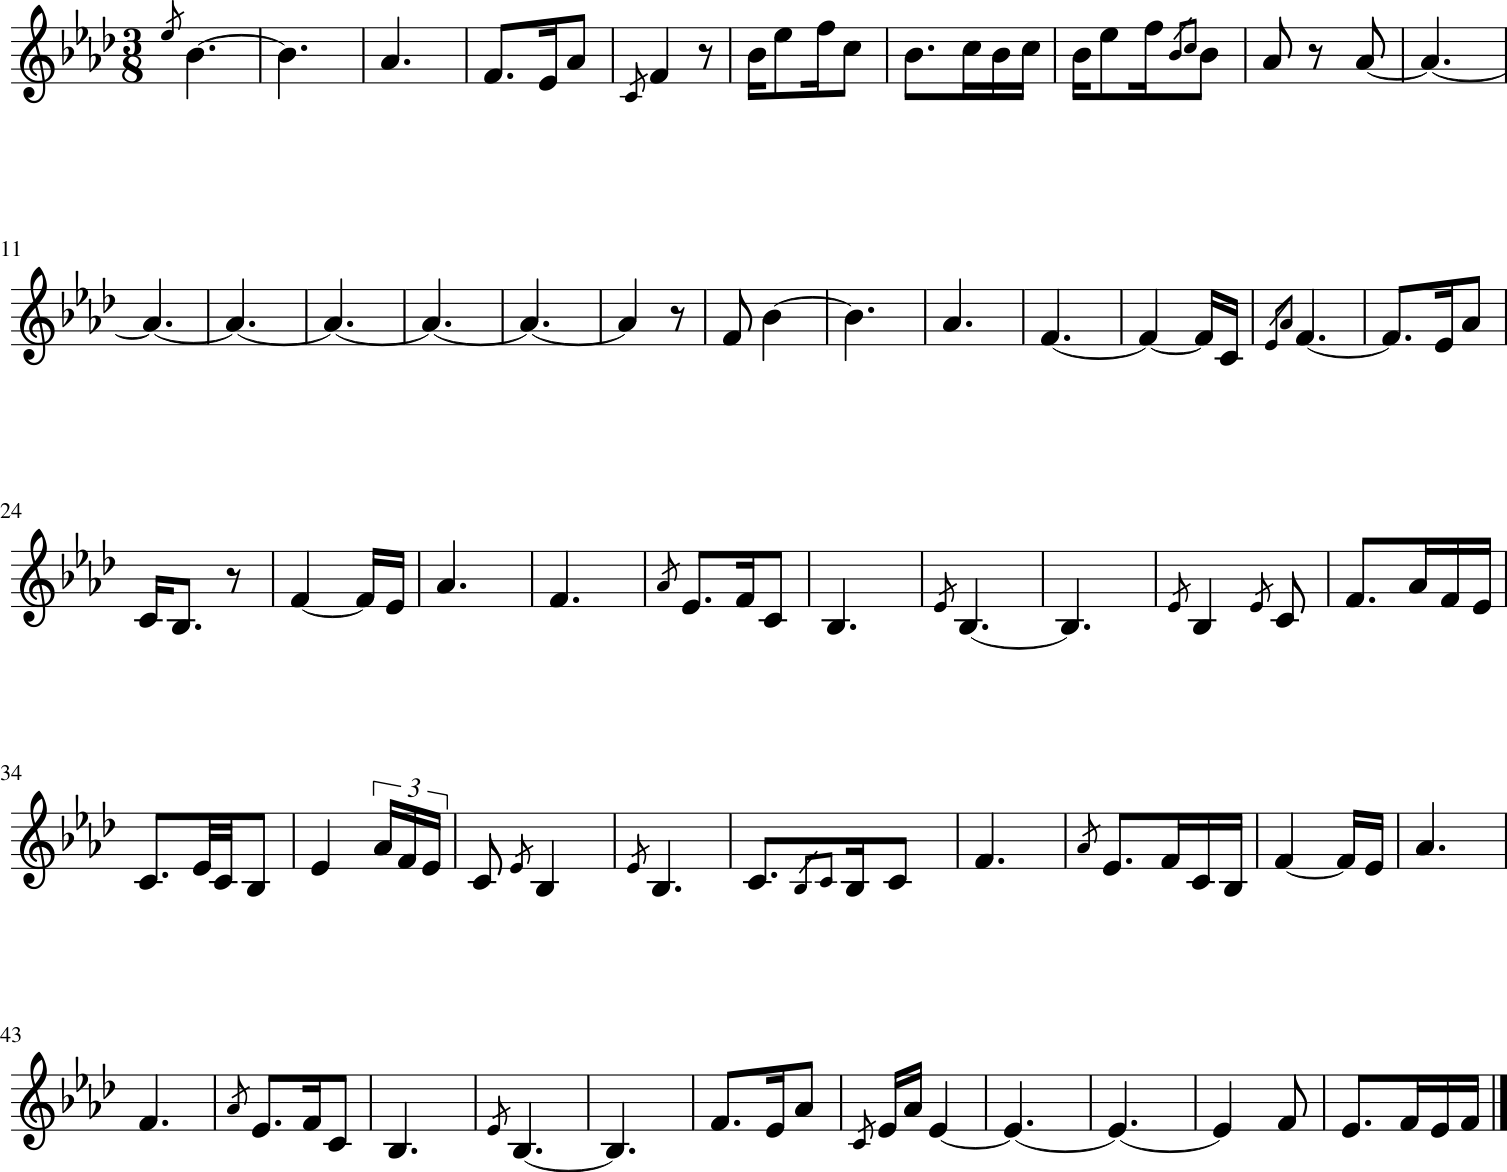

In [112]:
from typing import List
from sejong_music.jg_to_staff_converter import Note, JGToStaffConverter

cls = JGToStaffConverter

class ABCNote:
  def __init__(self, pitch:List[str], duration:float, global_offset:float):
    self.pitch = pitch[0]
    self.ornaments = pitch[1:]
    self.duration = duration
    self.global_offset = global_offset
    self.is_rest = self.pitch == '쉼표'
    self.midi_pitch = None
    self.m21_notes = []

  def __repr__(self) -> str:
    return f"ABCNote({self.pitch}_{'_'.join(self.ornaments)}, {self.duration}, {self.global_offset}, {self.is_rest})"


global_offset = 0
jg_offset = 0
gak_offset = 0
prev_pos = None
prev_note = []
total_notes = []
prev_duration = 0

for token in tokens:
  if token == '' or token in ('pad', 'start', 'end'): continue
  if token in cls.dur_tokens:
    duration = token
    if prev_note:
      total_notes.append(ABCNote(prev_note, duration, global_offset))
      prev_note = []
    global_offset += duration
    jg_offset += duration
  elif token  == '\n':
    gak_offset += 1
    jg_offset = 0
  else:
    prev_note.append(token)
# total_notes 
self.create_m21_notes(total_notes, verbose=True)
stream = self.convert_m21_notes_to_stream(total_notes)
stream.show()



In [93]:
type(total_notes[76].m21_notes[0])

music21.note.Note

In [88]:
total_notes[76].m21_notes[0].quarterLength

0.0

In [92]:
total_notes[77]

ABCNote(황_, 1/6, 48, False)

In [94]:
import music21
stream = music21.stream.Stream()
stream.append(total_notes[76].m21_notes[0])
stream.show()

MusicXMLExportException: In part (None), measure (1): Cannot convert durations without types to MusicXML.

In [60]:
stream

<music21.stream.Stream 0x7fc4d3f65a90>

In [61]:
for note in total_notes:
  for mnote in note.m21_notes:
    print(mnote.pitch, mnote.duration.quarterLength)
  

E-5 0.0
E-5 0.0
B-4 3.0
B-4 3.0
A-4 1.5
A-4 1.5
F4 0.75
F4 0.75
E-4 0.25
E-4 0.25
A-4 0.5
A-4 0.5
C4 0.0
C4 0.0
F4 1.0
F4 1.0


AttributeError: 'Rest' object has no attribute 'pitch'

In [23]:
decoder(' '.join(tokens))

([Note 배황(51)_슬기둥2 :2 @ 0+0 / 2,
  Note 배황(51)_ :0 @ 2+0 / 1,
  Note 하배황(39)_ :0 @ 3+0 / 1,
  Note 배황(51)_ :0 @ 4+0 / 1,
  Note 배황(51)_슬기둥2 :2 @ 5+0 / 2,
  Note 배황(51)_ :2 @ 7+0 / 2/3,
  Note 배중(56)_자출 :8 @ 7+2/3 / 1/3,
  Note 배중(56)_슬기둥2 :2 @ 8+0 / 2,
  Note 배중(56)_ :0 @ 10+0 / 1,
  Note 하배황(39)_ :0 @ 11+0 / 1,
  Note 배중(56)_ :0 @ 12+0 / 1,
  Note 배중(56)_슬기둥2 :2 @ 13+0 / 2,
  Note 배황(51)_ :2 @ 15+0 / 1/3,
  Note 배황(51)_ :5 @ 15+1/3 / 2/3,
  Note 배황(51)_ :0 @ 16+0 / 2,
  Note 하배임(46)_ :0 @ 18+0 / 1,
  Note 하배임(46)_ :0 @ 19+0 / 1,
  Note 배황(51)_ :0 @ 20+0 / 1,
  Note 배중(56)_슬기둥2 :2 @ 21+0 / 2,
  Note 배황(51)_ :2 @ 23+0 / 1/3,
  Note 배황(51)_ :5 @ 23+1/3 / 2/3,
  Note 하배임(46)_ :0 @ 24+0 / 1,
  Note 하배임(46)_ :0 @ 25+0 / 1,
  Note 하배임(46)_ :0 @ 26+0 / 1,
  Note 배황(51)_ :2 @ 27+0 / 2/3,
  Note 배황(51)_ :8 @ 27+2/3 / 4/3,
  Note 하배임(46)_ :0 @ 29+0 / 1,
  Note 하배임(46)_ :0 @ 30+0 / 1,
  Note 배황(51)_ :0 @ 31+0 / 1,
  Note 하배임(46)_슬기둥3 :2 @ 32+0 / 2,
  Note 하배임(46)_ :0 @ 34+0 / 1,
  Note 하배임(46)_ :

In [6]:
src, tgt, shifted_tgt = dataset[50]
device = 'cuda'
input_part_idx = src[0][-1]
target_part_idx = model.tokenizer.vocab[tgt[0][-1].item()]
# if input_part_idx < 2: continue
src, output, attn_map = inferencer.inference(src.to(device), target_part_idx)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
da

In [10]:
decoder.convert_inference_result(output, src, model.tokenizer.decode(shifted_tgt))

pitch 0 not in midi scales
note.midi_pitch is None in Note 전성(None)_느니-르 :8 @ 67+2/3 / -1/3
pitch None not in midi scales
note.midi_pitch is None in Note 쉼표(None)_덧길이표_리_청태_특강표 :0 @ 76+0 / 2/3
note.midi_pitch is None in Note 쉼표(None)_덧길이표_리_청태_특강표 :0 @ 76+0 / 2/3
note.midi_pitch is None in Note 쉼표(None)_덧길이표_리_청태_특강표 :0 @ 76+0 / 2/3
note.midi_pitch is None in Note 쉼표(None)_덧길이표_리_청태_특강표 :0 @ 76+0 / 2/3
pitch 84 not in midi scales


TypeError: 'NoneType' object is not subscriptable